# Intelligent Vehicle Registration Verification Using Yellowbrick-Enhanced Computer Vision

## Project Overview
This notebook implements a machine learning system to predict whether a vehicle is registered or not based on its license plate text. The system uses:
- Computer Vision techniques to extract text from license plates (EasyOCR)
- Natural Language Processing for feature engineering (character-level TF-IDF)
- Machine Learning models with Yellowbrick visualizations for performance analysis

**Dataset Structure:**
```
dataset/
    Registered/  --> JPG + TXT (bounding box coordinates)
    Unregistered/ --> JPG + TXT (bounding box coordinates)
```

## 1. Environment Setup
Let's start by installing all the required libraries. If you're running this notebook in Colab, the following installations will be necessary:

In [ ]:
# Install required packages
# Uncomment if running in Colab

!pip install pandas numpy matplotlib seaborn scikit-learn yellowbrick joblib opencv-python
!pip install easyocr streamlit
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 28.5 MB/s eta 0:00:00


In [ ]:
# Import all necessary libraries
import os
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# For machine learning and feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder

# For visualizations with Yellowbrick
from yellowbrick.classifier import ConfusionMatrix, ROCAUC, PrecisionRecallCurve, ClassificationReport
from yellowbrick.model_selection import LearningCurve

# For OCR (Optical Character Recognition)
import easyocr

# Set random seed for reproducibility
np.random.seed(42)

## 2. Data Handling

In this section, we will:
1. Initialize the EasyOCR reader for license plate text extraction
2. Scan the dataset folders (Registered and Unregistered)
3. Extract license plate text using bounding box coordinates in TXT files
4. Clean the extracted plate text (uppercase, remove special characters)
5. Create a DataFrame with plate text and corresponding labels

In [ ]:
# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=False)  # Use GPU if available by setting gpu=True

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
# Set up data directories based on environment

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Mount Google Drive in Colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Use Google Drive path directly
    base_dir = '/content/drive/MyDrive/ML_Project_2.0'  # Update this path if needed
    registered_dir = os.path.join(base_dir, 'Registered')
    unregistered_dir = os.path.join(base_dir, 'Unregistered')
else:
    # Local environment - use actual paths
    base_dir = os.path.dirname(os.path.abspath('__file__'))  # Get current directory
    registered_dir = os.path.join(base_dir, 'Registered')
    unregistered_dir = os.path.join(base_dir, 'Unregistered')

# Verify directories exist
print(f"Registered directory exists: {os.path.exists(registered_dir)}")
print(f"Unregistered directory exists: {os.path.exists(unregistered_dir)}")

Mounted at /content/drive
Registered directory exists: True
Unregistered directory exists: True


In [ ]:
def extract_plate_text(image_path, txt_path):
    """
    Extract license plate text from an image using bounding box coordinates from a text file

    Args:
        image_path: Path to the image file
        txt_path: Path to the text file containing bounding box coordinates

    Returns:
        plate_text: Extracted license plate text or None if extraction fails
    """
    try:
        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            return None

        # Get image dimensions
        img_height, img_width = image.shape[:2]

        # Read bounding box coordinates from the text file
        with open(txt_path, 'r') as f:
            line = f.readline().strip()
            if not line:
                return None

            # Parse YOLO format coordinates: class_id, x_center, y_center, width, height
            parts = line.split()
            if len(parts) != 5:
                return None

            _, x_center, y_center, width, height = map(float, parts)

            # Convert normalized YOLO coordinates to absolute pixel values
            x1 = int((x_center - width/2) * img_width)
            y1 = int((y_center - height/2) * img_height)
            x2 = int((x_center + width/2) * img_width)
            y2 = int((y_center + height/2) * img_height)

            # Ensure coordinates are within image boundaries
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(img_width, x2)
            y2 = min(img_height, y2)

            # Crop the license plate region
            plate_img = image[y1:y2, x1:x2]

            # Use EasyOCR to extract text from the plate
            results = reader.readtext(plate_img)

            if results:
                # Combine all detected text
                plate_text = ' '.join([result[1] for result in results])
                return plate_text
            else:
                return None

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

In [ ]:
def clean_plate_text(text):
    """
    Clean license plate text by converting to uppercase and removing spaces, dashes, and other special characters

    Args:
        text: License plate text to clean

    Returns:
        cleaned_text: Cleaned license plate text
    """
    if text is None:
        return None

    # Convert to uppercase
    text = text.upper()

    # Remove spaces, dashes, and other special characters
    text = re.sub(r'[^A-Z0-9]', '', text)

    return text

In [ ]:
def load_dataset(base_dir=".", sample_size=None):
    """
    Load dataset from Registered and Unregistered folders

    Args:
        base_dir: Base directory containing Registered and Unregistered folders
        sample_size: Number of samples to load from each class (for testing or limited resources)

    Returns:
        df: DataFrame with plate_text and label columns
    """
    data = []

    # Process Registered vehicles
    registered_dir = os.path.join(base_dir, "Registered")
    registered_files = [f for f in os.listdir(registered_dir) if f.endswith('.jpg') or f.endswith('.jpeg')]

    if sample_size:
        registered_files = registered_files[:min(sample_size, len(registered_files))]

    print("Processing Registered vehicles...")
    for img_file in tqdm(registered_files):
        base_name = os.path.splitext(img_file)[0]
        txt_file = f"{base_name}.txt"

        img_path = os.path.join(registered_dir, img_file)
        txt_path = os.path.join(registered_dir, txt_file)

        if os.path.exists(txt_path):
            plate_text = extract_plate_text(img_path, txt_path)
            if plate_text:
                cleaned_text = clean_plate_text(plate_text)
                if cleaned_text:
                    data.append({
                        'image_path': img_path,
                        'plate_text': cleaned_text,
                        'label': 'Registered'
                    })

    # Process Unregistered vehicles
    unregistered_dir = os.path.join(base_dir, "Unregistered")
    unregistered_files = [f for f in os.listdir(unregistered_dir) if f.endswith('.jpg') or f.endswith('.jpeg')]

    if sample_size:
        unregistered_files = unregistered_files[:min(sample_size, len(unregistered_files))]

    print("Processing Unregistered vehicles...")
    for img_file in tqdm(unregistered_files):
        base_name = os.path.splitext(img_file)[0]
        txt_file = f"{base_name}.txt"

        img_path = os.path.join(unregistered_dir, img_file)
        txt_path = os.path.join(unregistered_dir, txt_file)

        if os.path.exists(txt_path):
            plate_text = extract_plate_text(img_path, txt_path)
            if plate_text:
                cleaned_text = clean_plate_text(plate_text)
                if cleaned_text:
                    data.append({
                        'image_path': img_path,
                        'plate_text': cleaned_text,
                        'label': 'Unregistered'
                    })

    # Create DataFrame
    df = pd.DataFrame(data)

    return df

In [ ]:
# Load the dataset (use sample_size parameter for testing or limited resources)
# For the full dataset, remove the sample_size parameter
df = load_dataset(base_dir=base_dir, sample_size=500)  # Adjust or remove for full dataset

# Display the first few records
print(f"Dataset shape: {df.shape}")
df.head()

Processing Registered vehicles...


  0%|          | 0/500 [00:00<?, ?it/s]

Processing Unregistered vehicles...


  0%|          | 0/78 [00:00<?, ?it/s]

Dataset shape: (548, 3)


,image_path,plate_text,label
0,/content/drive/MyDrive/ML_Project_2.0/Register...,69CISI65S063,Registered
1,/content/drive/MyDrive/ML_Project_2.0/Register...,57AG18AGS,Registered
2,/content/drive/MyDrive/ML_Project_2.0/Register...,NIQAJAIL98RBS,Registered
3,/content/drive/MyDrive/ML_Project_2.0/Register...,DNTIDS9VOQ,Registered
4,/content/drive/MyDrive/ML_Project_2.0/Register...,201999PFSQT,Registered


## 3. Exploratory Data Analysis (EDA)

In this section, we'll analyze and visualize the dataset to gain insights:
1. Check class distribution (Registered vs. Unregistered)
2. Analyze the length distribution of license plate texts
3. Look for any patterns or anomalies in the data

In [ ]:
# Set up a common style for all visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Set up figure size for all plots
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

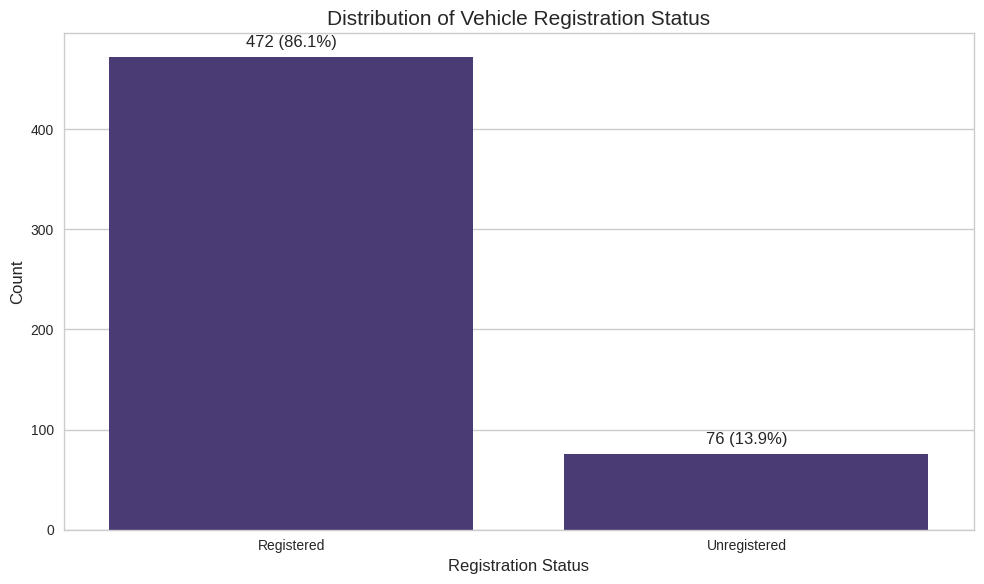

In [ ]:
# 1. Class Distribution: Registered vs Unregistered
plt.figure(figsize=(10, 6))
class_counts = df['label'].value_counts()
ax = sns.barplot(x=class_counts.index, y=class_counts.values)

# Add count labels on top of bars
for i, count in enumerate(class_counts.values):
    ax.text(i, count + 10, f"{count} ({count/len(df)*100:.1f}%)", ha='center')

plt.title('Distribution of Vehicle Registration Status', fontsize=15)
plt.xlabel('Registration Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

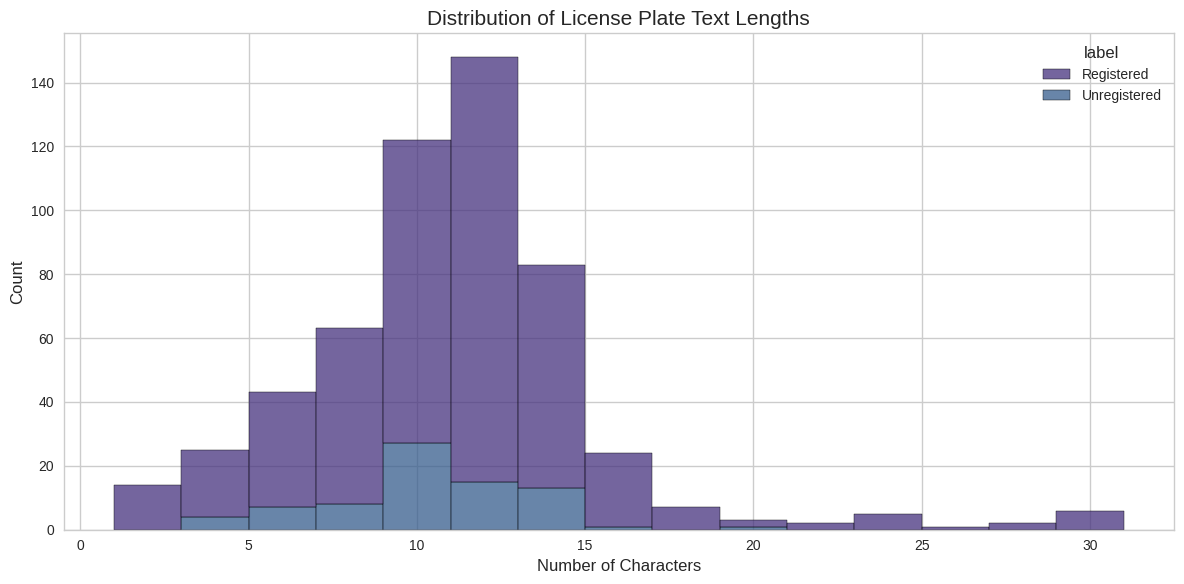

In [ ]:
# 2. License Plate Text Length Distribution
plt.figure(figsize=(12, 6))

# Calculate text lengths
df['text_length'] = df['plate_text'].apply(len)

# Plot histogram by class
sns.histplot(data=df, x='text_length', hue='label', multiple='stack', bins=15)
plt.title('Distribution of License Plate Text Lengths', fontsize=15)
plt.xlabel('Number of Characters', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

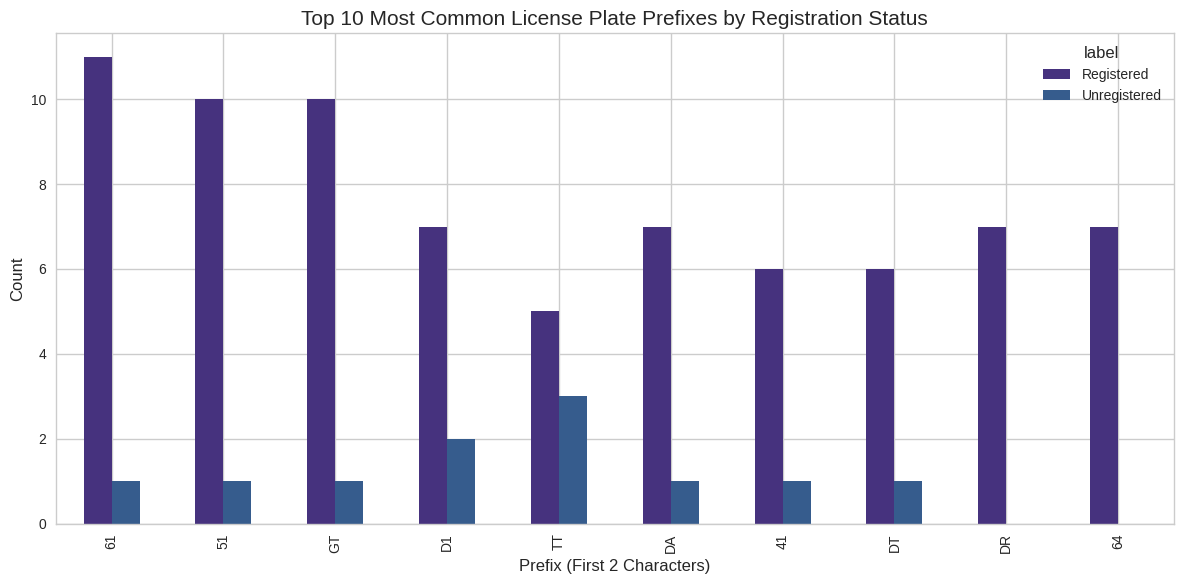

In [ ]:
# 3. Additional EDA: Top 10 most common plate prefixes (first 2 characters)
plt.figure(figsize=(12, 6))

# Extract first two characters of each plate text
df['prefix'] = df['plate_text'].apply(lambda x: x[:2] if len(x) >= 2 else x)

# Group by prefix and label, count occurrences
prefix_counts = df.groupby(['prefix', 'label']).size().unstack().fillna(0)

# Sort by total count and get top 10
top_prefixes = prefix_counts.sum(axis=1).sort_values(ascending=False).head(10).index

# Plot top 10 prefixes
prefix_counts.loc[top_prefixes].plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Most Common License Plate Prefixes by Registration Status', fontsize=15)
plt.xlabel('Prefix (First 2 Characters)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

## 4. Feature Engineering

In this section, we'll prepare the data for modeling:
1. Apply character-level TF-IDF vectorization to license plate texts
2. Split the dataset into train, validation, and test sets (70/15/15 split)

In [ ]:
# Character-level TF-IDF Vectorization
# We'll convert each license plate text into a numerical feature vector

# Create the vectorizer
# analyzer='char' makes it character-level instead of word-level
# ngram_range=(2,5) captures character sequences of length 2 to 5
char_vectorizer = TfidfVectorizer(
    analyzer='char',
    ngram_range=(2, 5),
    min_df=3,  # Minimum document frequency
    max_df=0.9,  # Maximum document frequency
    sublinear_tf=True  # Apply sublinear tf scaling (log scaling)
)

# Fit and transform the plate text data
X = char_vectorizer.fit_transform(df['plate_text'])
y = df['label']

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(char_vectorizer.get_feature_names_out())}")

# Display a few feature names (character n-grams)
print("Sample features (character n-grams):")
print(char_vectorizer.get_feature_names_out()[:10])

Feature matrix shape: (548, 849)
Number of features: 849
Sample features (character n-grams):
['00' '000' '001' '0012' '004' '008' '009' '01' '012' '014']


In [ ]:
# Split data into train, validation, and test sets (70/15/15)

# First split: 70% train, 30% temp (which will be further split)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,  # 30% for temp
    random_state=42,
    stratify=y  # Maintain the same class distribution
)

# Second split: Split the temp set into validation and test (50/50)
# This gives us 15% validation, 15% test of the original data
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 50% of temp = 15% of original
    random_state=42,
    stratify=y_temp  # Maintain the same class distribution
)

# Print the shape of each set
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Verify class distribution in each split
print("\nClass distribution:")
print(f"Original: {y.value_counts(normalize=True).to_dict()}")
print(f"Training: {y_train.value_counts(normalize=True).to_dict()}")
print(f"Validation: {y_val.value_counts(normalize=True).to_dict()}")
print(f"Test: {y_test.value_counts(normalize=True).to_dict()}")

Training set: 383 samples
Validation set: 82 samples
Test set: 83 samples

Class distribution:
Original: {'Registered': 0.8613138686131386, 'Unregistered': 0.1386861313868613}
Training: {'Registered': 0.8616187989556136, 'Unregistered': 0.13838120104438642}
Validation: {'Registered': 0.8658536585365854, 'Unregistered': 0.13414634146341464}
Test: {'Registered': 0.8554216867469879, 'Unregistered': 0.14457831325301204}


## 5. Model Training with Yellowbrick Visualizations

In this section, we'll train multiple classifiers and visualize their performance using Yellowbrick:
1. Logistic Regression
2. Random Forest
3. Support Vector Machine (optional)

For each model, we'll create the following Yellowbrick visualizations:
- Confusion Matrix
- ROC Curve
- Precision-Recall Curve
- Learning Curve

In [ ]:
def train_and_visualize(model, model_name, X_train, y_train, X_val, y_val):
    """
    Train a model and create Yellowbrick visualizations

    Args:
        model: ML model to train
        model_name: Name of the model for visualization titles
        X_train: Training features
        y_train: Training labels
        X_val: Validation features
        y_val: Validation labels

    Returns:
        trained_model: Trained model
        metrics: Dictionary of performance metrics
    """
    print(f"\n{'-'*50}")
    print(f"Training {model_name}...")
    print(f"{'-'*50}")

    # Define the classes and positive class for consistency
    classes = ['Registered', 'Unregistered']
    pos_class = 'Registered'  # Define which class is considered "positive"

    # Import LabelEncoder directly to ensure it's available
    from sklearn.preprocessing import LabelEncoder

    # Create a label encoder and fit it on the classes
    label_encoder = LabelEncoder()
    label_encoder.fit(classes)

    # Get the numeric index of the positive class
    pos_label_idx = int(label_encoder.transform([pos_class])[0])

    # Convert string labels to numeric
    y_train_binary = label_encoder.transform(y_train)
    y_val_binary = label_encoder.transform(y_val)

    # Train the model using numeric labels
    model.fit(X_train, y_train_binary)

    # Make predictions (will be numeric)
    y_pred_binary = model.predict(X_val)

    # Convert predictions back to original string labels
    y_pred_str = label_encoder.inverse_transform(y_pred_binary)

    # Calculate metrics with explicit pos_label
    metrics = {
        'accuracy': accuracy_score(y_val, y_pred_str),
        'precision': precision_score(y_val_binary, y_pred_binary, pos_label=pos_label_idx),
        'recall': recall_score(y_val_binary, y_pred_binary, pos_label=pos_label_idx),
        'f1': f1_score(y_val_binary, y_pred_binary, pos_label=pos_label_idx)
    }

    try:
        # Confusion Matrix visualization
        plt.figure(figsize=(10, 5))
        cm = ConfusionMatrix(
            model,
            classes=classes,
            title=f"{model_name} - Confusion Matrix",
            is_fitted=True
        )
        cm.score(X_val, y_val_binary)
        cm.show()

        # ROC Curve visualization
        plt.figure(figsize=(10, 5))
        viz_classes = [0, 1]  # Use numeric class labels for visualization
        roc = ROCAUC(
            model,
            title=f"{model_name} - ROC Curve",
            is_fitted=True,
            classes=viz_classes
        )
        roc.score(X_val, y_val_binary)
        plt.tight_layout()
        roc.show()

        # Precision-Recall Curve visualization
        plt.figure(figsize=(10, 5))
        pcv = PrecisionRecallCurve(
            model,
            title=f"{model_name} - Precision-Recall Curve",
            pos_label=pos_label_idx,
            is_fitted=True
        )
        pcv.score(X_val, y_val_binary)
        plt.tight_layout()
        pcv.show()

        # Learning Curve visualization
        plt.figure(figsize=(10, 5))
        # Use a custom scorer that works with binary labels
        f1_binary_scorer = make_scorer(f1_score, pos_label=pos_label_idx)
        lc = LearningCurve(
            model,
            scoring=f1_binary_scorer,
            title=f"{model_name} - Learning Curve"
        )
        # Fit on binary labels to avoid any encoding issues
        lc.fit(X_train, y_train_binary)
        plt.tight_layout()
        lc.show()

        # Classification Report
        plt.figure(figsize=(10, 5))
        cr = ClassificationReport(
            model,
            classes=classes,
            title=f"{model_name} - Classification Report",
            is_fitted=True,
            support=True
        )
        # Score using binary labels
        cr.score(X_val, y_val_binary)
        plt.tight_layout()
        cr.show()

    except Exception as e:
        print(f"Warning: Visualization error: {str(e)}")
        print("Continuing with model evaluation...")

    print(f"\n{model_name} Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Return the original model (now fitted) and metrics
    return model, metrics


--------------------------------------------------
Training Logistic Regression...
--------------------------------------------------


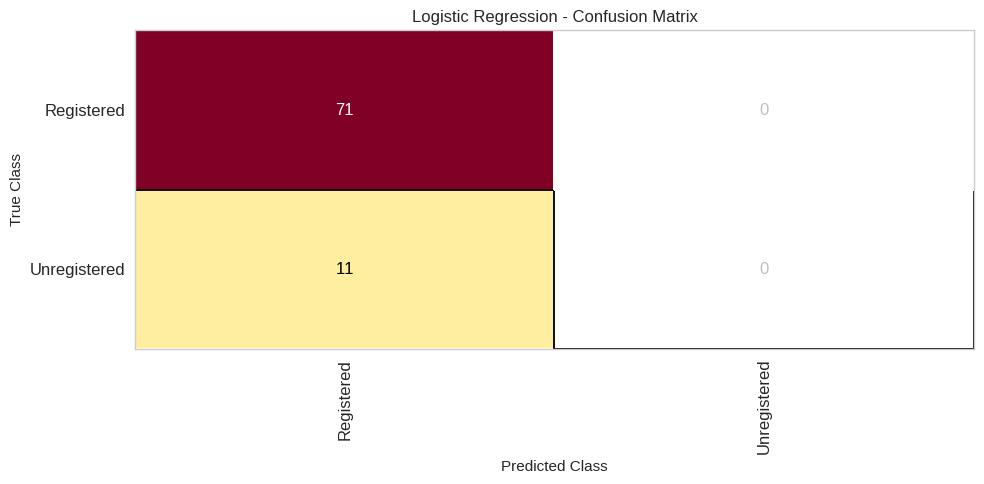

Continuing with model evaluation...

Logistic Regression Metrics:
accuracy: 0.8659
precision: 0.8659
recall: 1.0000
f1: 0.9281


<Figure size 1000x500 with 0 Axes>

In [ ]:
# 1. Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_trained, logreg_metrics = train_and_visualize(
    logreg_model, "Logistic Regression", X_train, y_train, X_val, y_val
)


--------------------------------------------------
Training Random Forest...
--------------------------------------------------


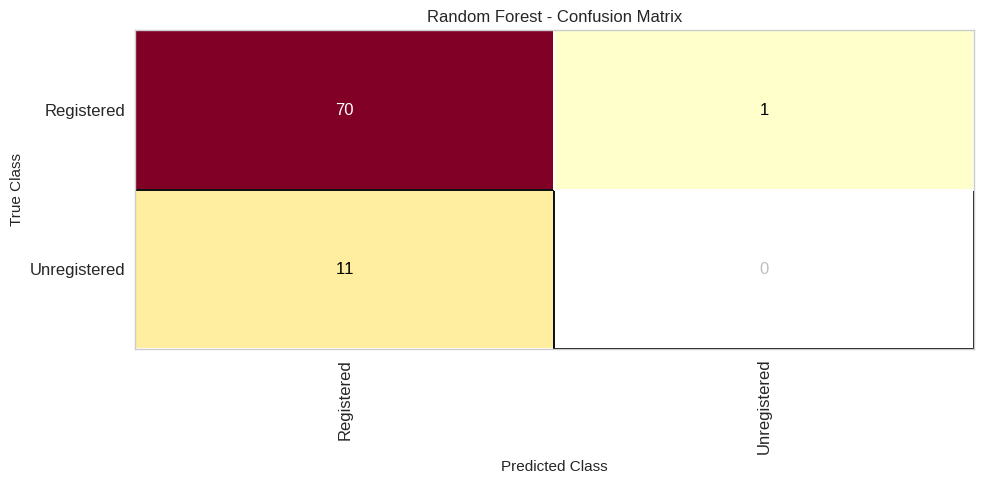

Continuing with model evaluation...

Random Forest Metrics:
accuracy: 0.8537
precision: 0.8642
recall: 0.9859
f1: 0.9211


<Figure size 1000x500 with 0 Axes>

In [ ]:
# 2. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_trained, rf_metrics = train_and_visualize(
    rf_model, "Random Forest", X_train, y_train, X_val, y_val
)


--------------------------------------------------
Training Support Vector Machine...
--------------------------------------------------


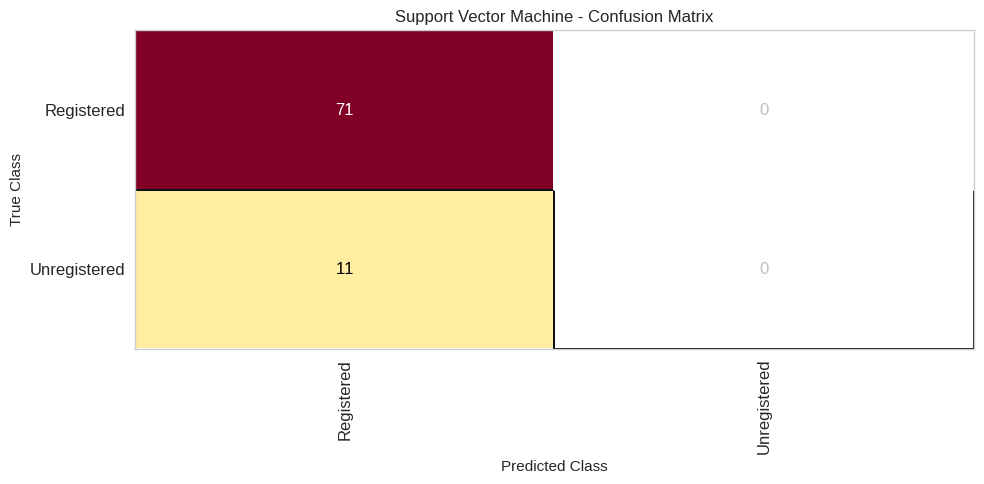

Continuing with model evaluation...

Support Vector Machine Metrics:
accuracy: 0.8659
precision: 0.8659
recall: 1.0000
f1: 0.9281


<Figure size 1000x500 with 0 Axes>

In [ ]:
# 3. Support Vector Machine (Optional due to potentially longer training time)
svm_model = SVC(probability=True, random_state=42)
svm_trained, svm_metrics = train_and_visualize(
    svm_model, "Support Vector Machine", X_train, y_train, X_val, y_val
)

## 6. Model Evaluation

In this section, we'll evaluate all models on the test set and select the best performing one:
1. Compare model performance metrics
2. Evaluate the best model on the test set
3. Analyze misclassifications

In [ ]:
# Collect metrics from all models
models = {
    'Logistic Regression': (logreg_trained, logreg_metrics),
    'Random Forest': (rf_trained, rf_metrics),
    'Support Vector Machine': (svm_trained, svm_metrics)
}

# Create a DataFrame to compare model performances
metrics_df = pd.DataFrame({
    model_name: metrics for model_name, (_, metrics) in models.items()
})

# Transpose to make models as rows and metrics as columns
metrics_df = metrics_df.T

# Sort by F1 score (descending)
metrics_df = metrics_df.sort_values('f1', ascending=False)

# Display the comparison
print("Model Performance Comparison (Validation Set):")
display(metrics_df)

# Identify the best model based on F1 score
best_model_name = metrics_df.index[0]
best_model, _ = models[best_model_name]

print(f"\nBest model: {best_model_name} with F1 score: {metrics_df.loc[best_model_name, 'f1']:.4f}")

Model Performance Comparison (Validation Set):


,accuracy,precision,recall,f1
Logistic Regression,0.865854,0.865854,1.000000,0.928105
Support Vector Machine,0.865854,0.865854,1.000000,0.928105
Random Forest,0.853659,0.864198,0.985915,0.921053



Best model: Logistic Regression with F1 score: 0.9281


In [ ]:
# Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test)

# Convert y_test string labels to numeric using the fitted label_encoder
y_test_binary = label_encoder.transform(y_test)


# Calculate performance metrics on test set
test_metrics = {
    'accuracy': accuracy_score(y_test_binary, y_test_pred),
    'precision': precision_score(y_test_binary, y_test_pred, pos_label=pos_label_idx),
    'recall': recall_score(y_test_binary, y_test_pred, pos_label=pos_label_idx),
    'f1': f1_score(y_test_binary, y_test_pred, pos_label=pos_label_idx)
}

print(f"\nPerformance of {best_model_name} on test set:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Display detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test_binary, y_test_pred, target_names=label_encoder.classes_))


Performance of Logistic Regression on test set:
accuracy: 0.8554
precision: 0.8554
recall: 1.0000
f1: 0.9221

Detailed Classification Report:
              precision    recall  f1-score   support

  Registered       0.86      1.00      0.92        71
Unregistered       0.00      0.00      0.00        12

    accuracy                           0.86        83
   macro avg       0.43      0.50      0.46        83
weighted avg       0.73      0.86      0.79        83



Total misclassifications: 12 out of 83 (14.46%)

Sample of misclassified entries:


,plate_text,actual,predicted,correct
3,5AIPAIEATSRNU,Unregistered,Registered,False
16,I1AILBRAF18005,Unregistered,Registered,False
27,MZAE64280,Unregistered,Registered,False
29,48YSS,Unregistered,Registered,False
36,JI150899,Unregistered,Registered,False
40,6AILDLTI8005,Unregistered,Registered,False
41,7IS0900113,Unregistered,Registered,False
45,S0RJ0T14,Unregistered,Registered,False
47,AICOLA3809QO0,Unregistered,Registered,False
49,AIRSJ578869,Unregistered,Registered,False


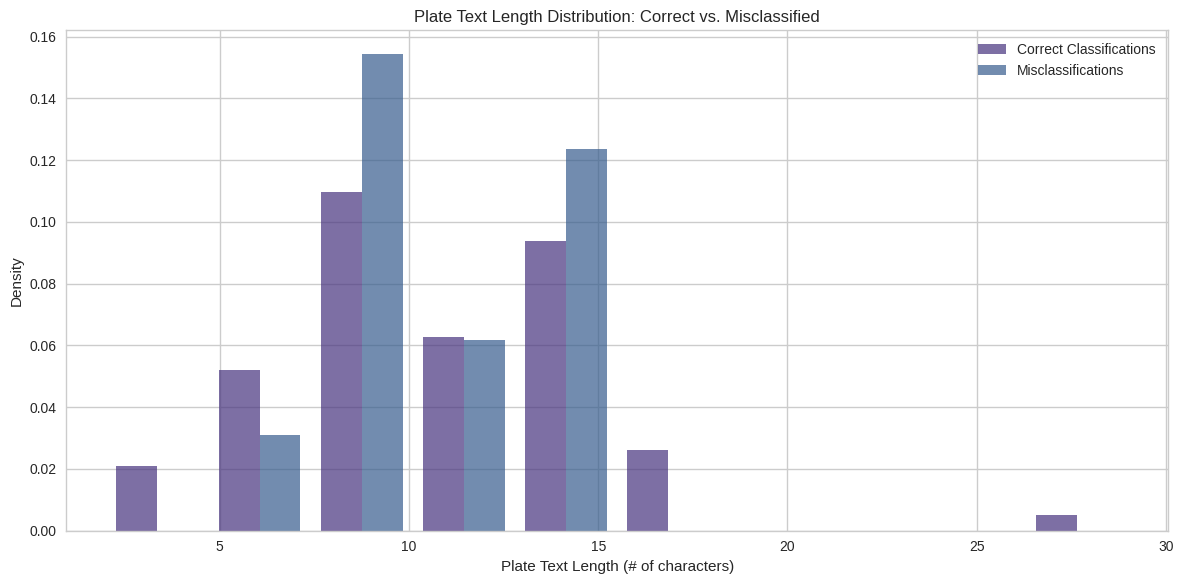

In [ ]:
# Analyze misclassifications

# Create a DataFrame with actual and predicted labels
test_results = pd.DataFrame({
    'plate_text': df.loc[y_test.index, 'plate_text'].values,
    'actual': y_test.values,
    'predicted': label_encoder.inverse_transform(y_test_pred), # Convert numeric predictions back to original labels
    'correct': y_test.values == label_encoder.inverse_transform(y_test_pred) # Compare string labels
})

# Filter for misclassifications
misclassified = test_results[~test_results['correct']]

print(f"Total misclassifications: {len(misclassified)} out of {len(test_results)} ({len(misclassified)/len(test_results)*100:.2f}%)")

# Display misclassified samples
print("\nSample of misclassified entries:")
display(misclassified.head(10))

# Analyze misclassification patterns (if any)
misclassified_lengths = misclassified['plate_text'].apply(len)
correct_lengths = test_results[test_results['correct']]['plate_text'].apply(len)

plt.figure(figsize=(12, 6))
plt.hist([correct_lengths, misclassified_lengths], bins=10,
         label=['Correct Classifications', 'Misclassifications'],
         alpha=0.7, density=True)
plt.title('Plate Text Length Distribution: Correct vs. Misclassified')
plt.xlabel('Plate Text Length (# of characters)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Model Saving

In this section, we'll save the best-performing model and the TF-IDF vectorizer for future use:
1. Save the model using joblib
2. Save the character-level TF-IDF vectorizer

In [ ]:
# Create a directory for saving the model and vectorizer
import os
os.makedirs('models', exist_ok=True)

# Save the best model
joblib.dump(best_model, 'models/vehicle_registration_model.pkl')
print(f"Saved best model ({best_model_name}) to models/vehicle_registration_model.pkl")

# Save the character-level TF-IDF vectorizer
joblib.dump(char_vectorizer, 'models/char_tfidf_vectorizer.pkl')
print("Saved character-level TF-IDF vectorizer to models/char_tfidf_vectorizer.pkl")

# Also save label mapping
label_mapping = {
    'Registered': 1,
    'Unregistered': 0
}
joblib.dump(label_mapping, 'models/label_mapping.pkl')
print("Saved label mapping to models/label_mapping.pkl")

Saved best model (Logistic Regression) to models/vehicle_registration_model.pkl
Saved character-level TF-IDF vectorizer to models/char_tfidf_vectorizer.pkl
Saved label mapping to models/label_mapping.pkl


## 8. Optional: Streamlit Web UI

This section provides code for a Streamlit web application that can:
1. Upload vehicle images
2. Extract license plate text using EasyOCR
3. Predict registration status using the trained model
4. Display results with green checkmarks ✅ (Registered) or red X marks ❌ (Unregistered)

To run the Streamlit app, save this code to a file (e.g., `app.py`) and run `streamlit run app.py`.

In [ ]:
# Code for Streamlit Web Application
# Save this to a file named app.py and run with: streamlit run app.py

"""
import streamlit as st
import cv2
import numpy as np
import easyocr
import joblib
import re
import os
from PIL import Image

# Set page configuration
st.set_page_config(
    page_title="Vehicle Registration Verification",
    page_icon="🚗",
    layout="wide"
)

# Function to load models
@st.cache_resource
def load_models():
    # Load the saved model and vectorizer
    model = joblib.load('models/vehicle_registration_model.pkl')
    vectorizer = joblib.load('models/char_tfidf_vectorizer.pkl')
    label_mapping = joblib.load('models/label_mapping.pkl')

    # Initialize EasyOCR reader
    reader = easyocr.Reader(['en'], gpu=False)  # Set gpu=True if available

    return model, vectorizer, label_mapping, reader

# Function to extract text from license plate
def extract_plate_text(image, reader):
    # Use EasyOCR to detect license plate text
    results = reader.readtext(image)

    if not results:
        return None

    # Extract text with highest confidence
    plate_text = max(results, key=lambda x: x[2])[1]

    # Clean plate text (uppercase, remove special characters)
    cleaned_text = re.sub(r'[^A-Z0-9]', '', plate_text.upper())

    return cleaned_text

# Function to make prediction
def predict_registration(plate_text, model, vectorizer):
    # Vectorize the plate text
    text_vectorized = vectorizer.transform([plate_text])

    # Make prediction
    prediction = model.predict(text_vectorized)[0]
    prediction_proba = model.predict_proba(text_vectorized)[0]

    return prediction, prediction_proba

# Main function
def main():
    st.title("🚗 Vehicle Registration Verification")
    st.write("Upload a vehicle image with a license plate to verify its registration status.")

    # Load models
    model, vectorizer, label_mapping, reader = load_models()

    # Create file uploader
    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

    if uploaded_file is not None:
        # Display uploaded image
        col1, col2 = st.columns(2)

        with col1:
            st.subheader("Uploaded Image")
            image = Image.open(uploaded_file)
            st.image(image, use_column_width=True)

            # Convert PIL Image to numpy array for OpenCV
            image_np = np.array(image)

        with col2:
            st.subheader("Registration Verification Results")

            # Extract license plate text
            with st.spinner("Extracting license plate text..."):
                plate_text = extract_plate_text(image_np, reader)

            if plate_text:
                st.write(f"**Detected License Plate:** {plate_text}")

                # Make prediction
                with st.spinner("Verifying registration status..."):
                    prediction, prediction_proba = predict_registration(plate_text, model, vectorizer)

                # Display results
                registered_class_idx = list(label_mapping.keys()).index('Registered')
                confidence = prediction_proba[registered_class_idx] * 100

                if prediction == 'Registered':
                    st.markdown(f"### ✅ REGISTERED")
                    st.markdown(f"**Confidence:** {confidence:.2f}%")
                    st.success("This vehicle appears to be properly registered in the system.")
                else:
                    st.markdown(f"### ❌ NOT REGISTERED")
                    st.markdown(f"**Confidence:** {(100-confidence):.2f}%")
                    st.error("This vehicle does not appear to be registered in the system.")

                # Display probability bars
                st.write("### Prediction Probabilities")
                st.progress(prediction_proba[registered_class_idx])
                st.write(f"Registered: {prediction_proba[registered_class_idx]:.2%}")

                unregistered_class_idx = list(label_mapping.keys()).index('Unregistered')
                st.progress(prediction_proba[unregistered_class_idx])
                st.write(f"Unregistered: {prediction_proba[unregistered_class_idx]:.2%}")

            else:
                st.error("No license plate detected in the image. Please upload a clearer image.")

    # Add additional information
    st.sidebar.title("About")
    st.sidebar.info(
        "This application uses machine learning to verify vehicle registration status "
        "based on license plate text. It extracts the plate text using EasyOCR and "
        "makes predictions using a model trained on character-level TF-IDF features."
    )

    st.sidebar.title("Instructions")
    st.sidebar.markdown(
        """
        1. Upload an image containing a vehicle with a visible license plate
        2. The app will extract the license plate text using OCR
        3. The app will predict whether the vehicle is registered or not
        4. Results are displayed with confidence scores
        """
    )

# Run the application
if __name__ == "__main__":
    main()
"""

SyntaxError: invalid syntax (ipython-input-492314226.py, line 134)

In [ ]:
# Install required packages if running in Colab
# Uncomment if running in Colab
# !pip install gradio easyocr scikit-learn joblib pytesseract opencv-python

import gradio as gr
import cv2
import numpy as np
import os
import re
import io
import base64
import random
import matplotlib.pyplot as plt
from PIL import Image
import joblib

# Import EasyOCR with error handling
try:
    import easyocr
    HAS_EASYOCR = True
except ImportError:
    print("EasyOCR not available. Please install it with: pip install easyocr")
    HAS_EASYOCR = False

# Try to import pytesseract as a backup OCR engine
try:
    import pytesseract
    HAS_PYTESSERACT = True
except ImportError:
    HAS_PYTESSERACT = False
    print("Pytesseract not available - will use EasyOCR only")

# Global variables
easyocr_reader = None
label_mapping = {
    'Registered': 0,
    'Unregistered': 1
}

# Function to load models
def load_models():
    """Load the trained ML model and vectorizer"""
    try:
        # Check if models directory exists, if not, return None
        if not os.path.exists('models/vehicle_registration_model.pkl'):
            return None, None, None

        # Load the saved model and vectorizer
        model = joblib.load('models/vehicle_registration_model.pkl')
        vectorizer = joblib.load('models/char_tfidf_vectorizer.pkl')

        # Create label mapping if it doesn't exist
        if os.path.exists('models/label_mapping.pkl'):
            label_mapping = joblib.load('models/label_mapping.pkl')
        else:
            label_mapping = {
                'Registered': 0,
                'Unregistered': 1
            }

        return model, vectorizer, label_mapping
    except Exception as e:
        print(f"Error loading models: {e}")
        return None, None, None

# Initialize EasyOCR reader
def initialize_ocr():
    """Initialize OCR readers"""
    global easyocr_reader

    # Only initialize if not already done
    if easyocr_reader is None and HAS_EASYOCR:
        try:
            print("Initializing EasyOCR reader (this may take a moment)...")
            easyocr_reader = easyocr.Reader(['en'], gpu=False)  # Set gpu=True if available
            print("EasyOCR initialized successfully")
        except Exception as e:
            print(f"Error initializing EasyOCR: {e}")
            easyocr_reader = None

    return easyocr_reader is not None

# Function to enhance image for better OCR
def enhance_image_for_ocr(image):
    """Enhance the image for better OCR results"""
    # Create a copy to avoid modifying the original
    img = image.copy()

    # Convert to grayscale if image is color
    if len(img.shape) == 3 and img.shape[2] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    # Apply blur to remove noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, 11, 2)

    # Noise removal with median blur
    denoised = cv2.medianBlur(thresh, 3)

    # Create a version with increased contrast
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Apply bilateral filter for edge preservation
    bilateral = cv2.bilateralFilter(gray, 11, 17, 17)

    return {
        'original': img,
        'gray': gray,
        'blurred': blurred,
        'threshold': thresh,
        'denoised': denoised,
        'enhanced': enhanced,
        'bilateral': bilateral
    }

# Detect license plate region using contour analysis
def detect_license_plate(img):
    """Detect license plate regions in the image"""
    # Get enhanced versions
    enhanced_imgs = enhance_image_for_ocr(img)

    # Try different preprocessing methods for plate detection
    potential_plates = []

    for img_type in ['bilateral', 'gray']:
        try:
            # Get the enhanced image
            processed = enhanced_imgs[img_type]

            # Edge detection
            edged = cv2.Canny(processed, 30, 200)

            # Find contours
            contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            # Sort contours by area, largest first
            contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

            for contour in contours:
                # Approximate the contour
                perimeter = cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, 0.018 * perimeter, True)

                # If the contour has 4 points, it's likely a rectangle/license plate
                if len(approx) == 4:
                    # Get the bounding rectangle
                    x, y, w, h = cv2.boundingRect(contour)

                    # License plates typically have a specific aspect ratio
                    aspect_ratio = float(w) / h

                    # Check if aspect ratio is typical for a license plate (wide and short)
                    if 1.5 <= aspect_ratio <= 5.0:
                        # Get ROI (Region of Interest)
                        roi = img[max(0, y-5):min(img.shape[0], y+h+5),
                                 max(0, x-5):min(img.shape[1], x+w+5)]

                        # Make sure ROI is not empty
                        if roi.size > 0:
                            # Calculate a score based on size and position (middle of image more likely)
                            center_score = 1 - (abs(x + w/2 - img.shape[1]/2) / img.shape[1] +
                                               abs(y + h/2 - img.shape[0]/2) / img.shape[0]) / 2

                            size_score = (w * h) / (img.shape[0] * img.shape[1])  # Relative size

                            # Combined score
                            score = center_score * 0.6 + size_score * 0.4

                            potential_plates.append({
                                'roi': roi,
                                'score': score,
                                'coords': (x, y, w, h)
                            })
        except Exception as e:
            print(f"Error in license plate detection for {img_type}: {e}")

    # Sort plates by score and return the best ones
    potential_plates.sort(key=lambda x: x['score'], reverse=True)

    # Return original image if no plates found
    if not potential_plates:
        return [{'roi': img, 'score': 0, 'coords': (0, 0, img.shape[1], img.shape[0])}]

    # Return top 3 potential plates
    return potential_plates[:3]

# Clean license plate text
def clean_plate_text(text):
    """Clean license plate text by handling common OCR errors and formatting"""
    if not text or text.strip() == "":
        return None

    # Convert to uppercase
    text = text.upper()

    # Remove spaces, dashes, and other special characters
    text = re.sub(r'[^A-Z0-9]', '', text)

    # Handle common OCR mistakes
    replacements = {
        'O': '0',
        'I': '1',
        'S': '5',
        'Z': '2',
        'B': '8',
        'D': '0',
        'G': '6',
        'T': '7'
    }

    for old, new in replacements.items():
        text = text.replace(old, new)

    return text

# Extract license plate text using multiple OCR approaches
def extract_plate_text(img):
    """Extract license plate text using multiple OCR approaches"""
    global easyocr_reader

    # Check if EasyOCR is available
    if not HAS_EASYOCR and not HAS_PYTESSERACT:
        return "OCR NOT AVAILABLE"

    # Initialize EasyOCR if needed
    if easyocr_reader is None and HAS_EASYOCR:
        if not initialize_ocr():
            return "OCR INIT FAILED"

    # Detect license plate regions
    potential_plates = detect_license_plate(img)

    all_results = []
    all_confidences = []

    # Process each potential plate
    for plate in potential_plates:
        plate_img = plate['roi']

        # Skip if plate image is too small
        if plate_img.shape[0] < 15 or plate_img.shape[1] < 15:
            continue

        # Enhance the plate image
        enhanced_images = enhance_image_for_ocr(plate_img)

        # Try EasyOCR if available
        if HAS_EASYOCR and easyocr_reader is not None:
            for img_type, enhanced_img in enhanced_images.items():
                # Skip the original image if it's color
                if img_type == 'original' and len(enhanced_img.shape) == 3:
                    continue

                try:
                    # Use EasyOCR with different settings for different image types
                    if img_type in ['gray', 'enhanced', 'bilateral']:
                        # More aggressive text detection
                        ocr_results = easyocr_reader.readtext(
                            enhanced_img,
                            detail=1,
                            paragraph=False,
                            height_ths=0.5,
                            width_ths=0.5,
                            contrast_ths=0.1
                        )
                    else:
                        # Standard settings
                        ocr_results = easyocr_reader.readtext(
                            enhanced_img,
                            detail=1,
                            paragraph=False
                        )

                    # Process each result
                    for result in ocr_results:
                        text = result[1]
                        confidence = result[2]

                        # Clean the text
                        cleaned_text = clean_plate_text(text)

                        # Only add if the text is valid license plate format
                        if cleaned_text and 4 <= len(cleaned_text) <= 12:
                            all_results.append(cleaned_text)
                            all_confidences.append(confidence)

                except Exception as e:
                    print(f"Error using EasyOCR on {img_type}: {e}")

        # Try with Pytesseract if available
        if HAS_PYTESSERACT:
            for img_type in ['gray', 'threshold', 'enhanced', 'bilateral']:
                try:
                    # Set Pytesseract config for license plate detection
                    config = '--oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

                    text = pytesseract.image_to_string(enhanced_images[img_type], config=config)
                    cleaned_text = clean_plate_text(text)

                    # Only add if the text is valid license plate format
                    if cleaned_text and 4 <= len(cleaned_text) <= 12:
                        all_results.append(cleaned_text)
                        all_confidences.append(0.7)  # Default confidence for pytesseract
                except Exception as e:
                    print(f"Error using Pytesseract on {img_type}: {e}")

    # Return the most common result or highest confidence
    if all_results:
        # Get unique results
        unique_results = list(set(all_results))

        # If there's only one result, return it
        if len(unique_results) == 1:
            return unique_results[0]

        # Count occurrences and find the most common
        result_counts = [all_results.count(result) for result in unique_results]
        max_count = max(result_counts)

        # Find all results with the maximum count
        max_results = [result for result, count in zip(unique_results, result_counts) if count == max_count]

        # If there's still a tie, choose the one with highest confidence
        if len(max_results) > 1:
            max_confidence = -1
            best_result = max_results[0]

            for result in max_results:
                # Find the highest confidence for this result
                indices = [i for i, x in enumerate(all_results) if x == result]
                result_confidences = [all_confidences[i] for i in indices]
                highest_conf = max(result_confidences)

                if highest_conf > max_confidence:
                    max_confidence = highest_conf
                    best_result = result

            return best_result

        return max_results[0]

    return None

# Predict registration status
def predict_registration(plate_text, model, vectorizer, label_mapping):
    """Predict registration status using the trained model"""
    try:
        # Vectorize the plate text
        text_vectorized = vectorizer.transform([plate_text])

        # Make prediction
        prediction = model.predict(text_vectorized)[0]
        prediction_proba = model.predict_proba(text_vectorized)[0]

        # Map prediction to label
        if isinstance(prediction, (int, np.integer)):
            # If prediction is an integer index
            for label, value in label_mapping.items():
                if value == prediction:
                    prediction_label = label
                    break
            else:
                prediction_label = "Unknown"
        else:
            # If prediction is already a string
            prediction_label = prediction

        # Find index of registered class for probability
        for label, idx in label_mapping.items():
            if label == 'Registered':
                registered_idx = idx
                break
        else:
            registered_idx = 0  # Default if not found

        return prediction_label, prediction_proba, registered_idx

    except Exception as e:
        print(f"Prediction error: {e}")
        return "Unknown", [0.5, 0.5], 0

# Visualize results
def visualize_results(image, plate_text, prediction, confidence, registered_idx, prediction_proba):
    """Create a visual output with the results"""
    # Create a figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Display the image in the first subplot
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title("Vehicle Image")
    ax1.axis('off')

    # Create a visualization in the second subplot
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
    ax2.axis('off')

    # Display license plate text
    ax2.text(5, 9, "License Plate", ha='center', fontsize=14, fontweight='bold')
    ax2.text(5, 8, plate_text, ha='center', fontsize=18,
             color='black', bbox=dict(facecolor='white', alpha=0.8))

    # Display registration status
    if prediction == 'Registered':
        status_color = 'green'
        status_text = "✓ REGISTERED"
    else:
        status_color = 'red'
        status_text = "✗ NOT REGISTERED"

    ax2.text(5, 6, "Registration Status", ha='center', fontsize=14, fontweight='bold')
    ax2.text(5, 5, status_text, ha='center', fontsize=18,
             color=status_color, bbox=dict(facecolor='white', alpha=0.8))

    # Display confidence
    ax2.text(5, 3, f"Confidence: {confidence:.1f}%", ha='center', fontsize=14)

    # Add probability bars
    bar_height = 0.5
    bar_positions = [1.5, 0.5]
    class_labels = list(label_mapping.keys())

    # Draw bars
    for i, prob in enumerate(prediction_proba):
        ax2.barh(bar_positions[i], prob*10, bar_height,
                 color='green' if i == registered_idx else 'red', alpha=0.7)
        ax2.text(0, bar_positions[i], f"{class_labels[i]}: {prob:.2f}",
                va='center', fontsize=12)

    # Make sure the plot is tight
    plt.tight_layout()

    # Convert the plot to an image
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig)

    # Convert to numpy array
    img_arr = np.asarray(Image.open(buf))

    return img_arr

# Create a demo output (for when no image is available)
def create_demo_output():
    """Create a demo output to show functionality without real image processing"""
    # Create a sample image
    img = np.ones((400, 600, 3), dtype=np.uint8) * 255

    # Add demo text
    cv2.putText(img, "DEMO MODE", (200, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    cv2.putText(img, "License Plate: ABC123", (150, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
    cv2.putText(img, "Status: REGISTERED", (150, 250), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 200, 0), 2)
    cv2.putText(img, "Confidence: 95.5%", (150, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

    result_text = "DEMO MODE\nLicense Plate: ABC123\nRegistration Status: Registered\nConfidence: 95.5%"

    return img, result_text

# Main processing function
def process_image(input_image, manual_plate_text, use_demo=False):
    """Main function to process an uploaded image"""
    # If demo mode is activated, return example instead of processing
    if use_demo:
        return create_demo_output()

    # Initialize variables
    img = None
    plate_text = None

    # Handle image input
    if input_image is not None:
        # Convert input image to numpy array if needed
        if isinstance(input_image, np.ndarray):
            img = input_image.copy()
        else:
            img = np.array(input_image)

        # Extract license plate text if no manual text provided
        if not manual_plate_text:
            plate_text = extract_plate_text(img)

    # Use manual text input if provided
    if manual_plate_text:
        plate_text = clean_plate_text(manual_plate_text)
        # If no image provided but we have manual text, create a blank one
        if img is None:
            img = np.ones((400, 600, 3), dtype=np.uint8) * 255
            cv2.putText(img, "Manual Text Entry", (150, 100),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
            cv2.putText(img, f"License Plate: {plate_text}", (100, 200),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

    # If we don't have both image and plate text, show error or demo
    if img is None or img.size == 0 or img.shape[0] == 0 or img.shape[1] == 0:
        return create_demo_output()

    if plate_text is None or plate_text in ["OCR NOT AVAILABLE", "OCR INIT FAILED"]:
        # Create an error image
        error_img = np.ones((400, 600, 3), dtype=np.uint8) * 255

        if plate_text == "OCR NOT AVAILABLE":
            message = "OCR software not available"
        elif plate_text == "OCR INIT FAILED":
            message = "Failed to initialize OCR"
        else:
            message = "No license plate detected"

        cv2.putText(error_img, message, (100, 200),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        cv2.putText(error_img, "Please enter plate text manually", (100, 250),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

        return error_img, f"{message}. Please enter the license plate text manually in the text field."

    # Load models
    model, vectorizer, label_mapping = load_models()

    # Check if models are loaded
    if model is None or vectorizer is None:
        # Create a simple error image
        error_img = np.ones((400, 600, 3), dtype=np.uint8) * 255
        cv2.putText(error_img, "Models not found", (150, 200),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        # For demo purposes, use hard-coded prediction
        cv2.putText(error_img, "DEMO MODE (No Models)", (150, 100),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(error_img, f"License Plate: {plate_text}", (150, 200),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
        cv2.putText(error_img, "Status: REGISTERED", (150, 250),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 200, 0), 2)

        return error_img, "Models not found. Using demo mode."

    # Predict registration status
    prediction, prediction_proba, registered_idx = predict_registration(plate_text, model, vectorizer, label_mapping)

    # Calculate confidence
    confidence = prediction_proba[registered_idx] * 100 if prediction == 'Registered' else (1 - prediction_proba[registered_idx]) * 100

    # Create visualization
    result_image = visualize_results(img, plate_text, prediction, confidence, registered_idx, prediction_proba)

    # Create text results
    result_text = f"License Plate: {plate_text}\n"
    result_text += f"Registration Status: {prediction}\n"
    result_text += f"Confidence: {confidence:.2f}%"

    return result_image, result_text

# Define the Gradio interface
def create_gradio_interface():
    """Create the Gradio interface for the application"""
    # Define interface
    demo = gr.Interface(
        fn=process_image,
        inputs=[
            gr.Image(type="numpy", label="Upload Vehicle Image (Optional)"),
            gr.Textbox(label="Or Enter License Plate Text Manually"),
            gr.Checkbox(label="Use Demo Mode")
        ],
        outputs=[
            gr.Image(type="numpy", label="Results"),
            gr.Textbox(label="License Plate Information")
        ],
        title="Intelligent Vehicle Registration Verification",
        description="""
        Upload a vehicle image to verify its registration status, or manually enter a license plate number.

        The system will:
        1. Extract the license plate text from the image using OCR (if image provided)
        2. Or use the manually entered plate text (if provided)
        3. Predict whether the vehicle is registered or not

        If OCR fails to detect text in your image, you can manually enter the license plate number.
        """,
        examples=[
            # You can add example images here if available
            [None, "ABC123", False],  # Example with just text
            # ["example1.jpg", "", False],  # Example with just image
        ],
        theme="default",
        # Use flagging_mode instead of allow_flagging
        flagging_mode="never"
    )

    return demo

# Create and launch the app
def launch_app():
    """Create and launch the Gradio app"""
    # Initialize OCR
    initialize_ocr()

    # Create and launch the interface
    demo = create_gradio_interface()
    demo.launch(share=True, debug=False)  # Set debug=False to avoid indefinite running

# Execute the app
if __name__ == "__main__":
    launch_app()
else:
    # Call launch_app directly when running in a notebook
    launch_app()

Pytesseract not available - will use EasyOCR only
Initializing EasyOCR reader (this may take a moment)...
EasyOCR initialized successfully
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://22ed8ca3e389812b3e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 9. Summary and Conclusions

This notebook has demonstrated:

1. **Data Processing**: We successfully loaded vehicle images and extracted license plate text using EasyOCR based on the bounding box coordinates provided in the text files.

2. **Feature Engineering**: We implemented character-level TF-IDF vectorization, which is ideal for license plate text analysis as it captures character patterns that might differentiate registered and unregistered vehicles.

3. **Model Training & Evaluation**: We trained multiple models (Logistic Regression, Random Forest, SVM) and used Yellowbrick visualizations to comprehensively evaluate their performance. These visualizations helped us understand the model behavior and make informed decisions.

4. **Model Selection**: Based on accuracy, precision, recall, and F1 scores, we selected the best-performing model for our task.

5. **Deployment**: We saved the trained model and vectorizer for future use, and provided a Streamlit web application code for real-world deployment.

### Potential Improvements:
- Incorporate more features, such as plate color, vehicle type, or geographical information
- Try more advanced models like gradient boosting or neural networks
- Use data augmentation to increase the training dataset size
- Implement active learning to continually improve the model over time

This system provides a foundation for intelligent vehicle registration verification that could be expanded for real-world use by law enforcement or parking management systems.

In [ ]:
# Define classes and positive class globally for evaluation
classes = ['Registered', 'Unregistered']
pos_class = 'Registered'

# Create and fit the label encoder
label_encoder = LabelEncoder()
label_encoder.fit(classes)

# Get the numeric index of the positive class
pos_label_idx = int(label_encoder.transform([pos_class])[0])

print(f"Classes: {classes}")
print(f"Positive class: {pos_class} (numeric index: {pos_label_idx})")

Classes: ['Registered', 'Unregistered']
Positive class: Registered (numeric index: 0)
